## Import Packages

In [2]:
import rdkit
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn import neighbors
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import metrics 

## Read files and create dataframe with Smiles

In [7]:
df_smiles1 = pd.read_csv('tested_molecules-1.csv')
df_smiles2 = pd.read_csv('tested_molecules_v2.csv')
df_test_smiles = pd.read_csv('untested_molecules.csv')

df_smiles_tested = pd.concat([df_smiles1, df_smiles2], ignore_index=True)

df_smiles = pd.concat([df_smiles1, df_smiles2, df_test_smiles], ignore_index=True)
print(df_smiles)

                                                  SMILES  ALDH1_inhibition
0      COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...               1.0
1                 O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1               1.0
2      Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...               1.0
3                      CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1               1.0
4      CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21               1.0
...                                                  ...               ...
11995                         CCNC(=O)c1nc[nH]c1C(=O)NCC               NaN
11996  CCC(C)C(NC(=O)C(C)NC(=O)CNC(=O)CNC(=O)OCc1cccc...               NaN
11997  O=C(CSc1ncnc2ccccc12)Nc1cccc(S(=O)(=O)N2CCOCC2)c1               NaN
11998                  Cc1cc(OCCOCC[NH+](C)CCO)cc(C)c1Cl               NaN
11999  CC(C)C(C(=O)NCc1ccco1)N(C(=O)CNS(=O)(=O)c1cccc...               NaN

[12000 rows x 2 columns]


## Check descriptor values for all Smiles

In [9]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [10]:
allDescrs = []
for _, row in df_smiles.iterrows():
    mol = row['SMILES']
    m = Chem.MolFromSmiles(mol)
    descriptors = getMolDescriptors(m)
    allDescrs.append(descriptors)
    
df_descr = pd.DataFrame(allDescrs)
df_descr.head()


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,178,0,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,136,0,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,184,0,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,96,0,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,12.108866,0.086947,-3.251317,0.687618,419.553,402.417,419.043204,140,0,...,0,1,0,0,0,1,0,1,0,0


## Data cleaning

Delete the collumns that have only one unique value, so a column where each value is the mean, and variance is 0

In [11]:
#Deletes colums with nonsense values (only the same values)
bad_descr=[]
for i in df_descr.columns:
    if df_descr[i].nunique() == 1:
        bad_descr.append(i)
print(bad_descr)       
df_nonzero=df_descr.drop(columns=bad_descr)  

['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_azide', 'fr_isocyan', 'fr_isothiocyan', 'fr_prisulfonamd']


Remove variables so that no variables are left that have a hcorralation with another variable higher than the set threshold for corralation

In [12]:
corrThreshold = 0.90


correlation_mat = df_nonzero.corr()
upper_tri = correlation_mat.where(np.triu(np.ones(correlation_mat.shape),k=1).astype(bool)) 
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > corrThreshold)] 
df_noCorr = df_nonzero.drop(columns=to_drop)



df_noCorr.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,0.001173,-0.683140,0.520365,463.542,0.249868,-0.496477,1.088235,16.465857,10.012387,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,0.066966,-0.066966,0.498564,378.457,0.230353,-0.467476,1.111111,32.166556,10.202245,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,0.016881,-0.016881,0.382043,477.589,0.219930,-0.492903,1.228571,16.492058,9.989823,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,0.270607,-0.454447,0.795948,330.609,0.351723,-0.421732,1.333333,79.918731,10.173315,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,0.086947,-3.251317,0.687618,419.553,0.231765,-0.301646,1.296296,32.233291,10.071048,...,0,1,0,0,0,1,0,1,0,0


## Scale data & perform PCA

In [13]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_noCorr)

pca = PCA(n_components = 48)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

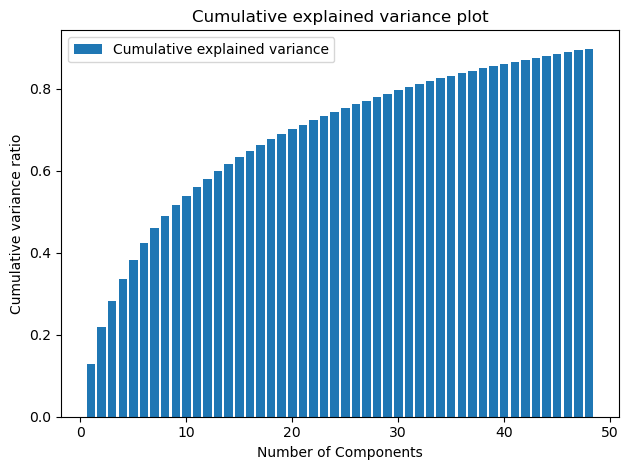

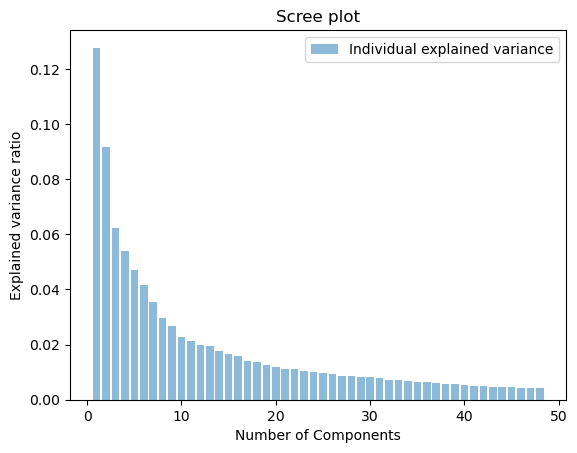

In [18]:
plt.bar(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, align='center',label='Cumulative explained variance');
plt.ylabel('Cumulative variance ratio')
plt.xlabel('Number of Components')
plt.title('Cumulative explained variance plot',fontsize=12)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#scree plot om aantal PCA te bepalen
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance');
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Components')
plt.title('Scree plot',fontsize=12)
plt.legend(loc='best')
plt.show()

## Split data for testing

In [16]:
features = principalDf.iloc[0:df_smiles_tested.shape[0]]#np.array(principalDf)
target = np.array(df_smiles_tested['ALDH1_inhibition'])

### Training & test set

In [17]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size = 0.20, random_state = 42)

#check the shapes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1600, 48)
Training Labels Shape: (1600,)
Testing Features Shape: (400, 48)
Testing Labels Shape: (400,)


In [50]:
test_labels.sum()

120

## Predictor models

### Random Forest Regressor Model

In [18]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

Predictions

In [19]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [20]:
def get_labels(threshold, predictions):
    " Classify the predictions in category 1 or 0, based on the given threhold parameters"
    predicted_labels = []
    for i in predictions:
        if i>= threshold:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    return  predicted_labels

In [21]:
# Get the labels from the predictions
rf_predicted_labels = get_labels(0.5, predictions)

accuracy 0.7333333333333334
specificity 0.85
sensitivity 0.6166666666666667


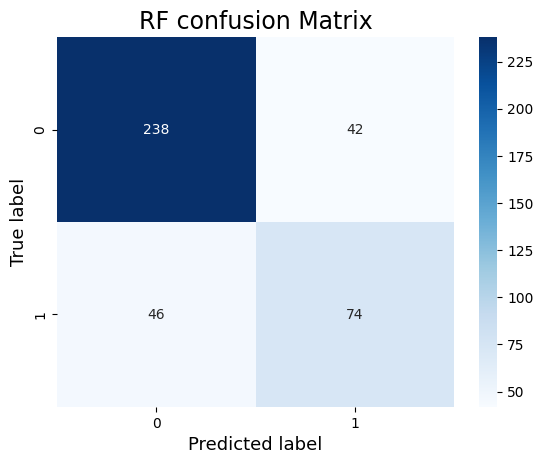

In [51]:
# Calculate the balanced accuracy
d={'predictions':predictions, 'predicted_labels':rf_predicted_labels, 'true_labels':test_labels}
rf_results = pd.DataFrame(d) 
#print(rf_results)
rf_acc = metrics.balanced_accuracy_score(rf_results['true_labels'], rf_results['predicted_labels'] )
print("accuracy", rf_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(rf_results['true_labels'], rf_results['predicted_labels']).ravel()
cm = confusion_matrix(rf_results['true_labels'], rf_results['predicted_labels'])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('True label',fontsize=13)
plt.xlabel('Predicted label',fontsize=13)
plt.title('RF confusion Matrix',fontsize=17)
plt.show()

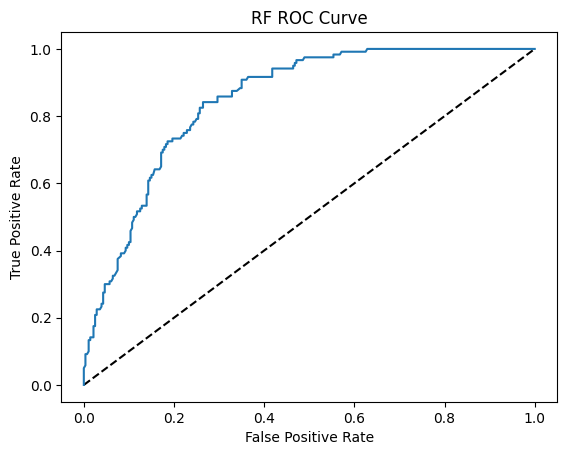

In [23]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(rf_results['true_labels'], rf_results['predictions'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC Curve')
plt.show()

### Random Forest Classifier Model

In [ ]:
clf=RandomForestClassifier()
clf.fit(train_features, train_labels)

In [ ]:
# Get predictions 
preds = clf.predict(test_features)
print ("accuracy of the training set",clf.score(train_features, train_labels))
print("accuracy of the test set" ,clf.score(test_features, test_labels))

rf_acc = metrics.balanced_accuracy_score(test_labels, preds)
print(rf_acc)

## Support vector machine

### Support vector regressor

In [24]:
# Make a default SVR model and calculate the labels from the predictions
SVR_model_default = SVR()
SVR_model_default.fit(train_features, train_labels)
y_pred_SVR_default = SVR_model_default.predict(test_features)
svr_predicted_labels = get_labels(0.5, y_pred_SVR_default)
#print(y_pred_SVR_default)

     predictions  predicted_labels  true_labels
0       0.585443                 1            1
1       0.151955                 0            0
2      -0.087982                 0            0
3       0.094105                 0            0
4       0.039371                 0            0
..           ...               ...          ...
395     0.095819                 0            0
396    -0.028755                 0            0
397     0.885156                 1            1
398     0.895773                 1            1
399     0.039952                 0            0

[400 rows x 3 columns]
accuracy 0.7333333333333334
specificity 0.8642857142857143
sensitivity 0.6833333333333333


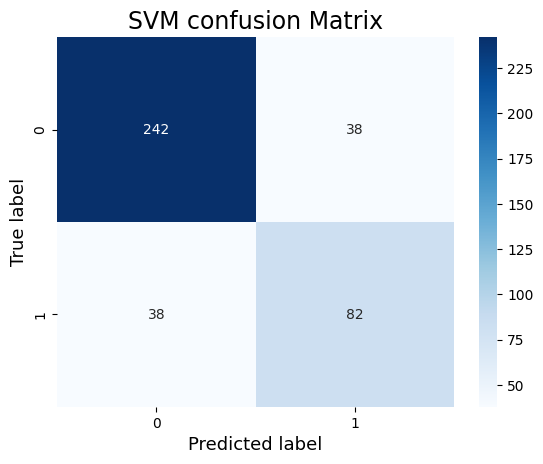

In [52]:
# Calculate the balanced accuracy
d={'predictions':y_pred_SVR_default, 'predicted_labels':svr_predicted_labels, 'true_labels':test_labels}
svr_default_results = pd.DataFrame(d) 
print(svr_default_results)

svr_default_acc = metrics.balanced_accuracy_score(svr_default_results['true_labels'], svr_default_results['predicted_labels'] )
print("accuracy", rf_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(svr_default_results['true_labels'], svr_default_results['predicted_labels']).ravel()
cm = confusion_matrix(svr_default_results['true_labels'], svr_default_results['predicted_labels'])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('True label',fontsize=13)
plt.xlabel('Predicted label',fontsize=13)
plt.title('SVM confusion Matrix',fontsize=17)
plt.show()

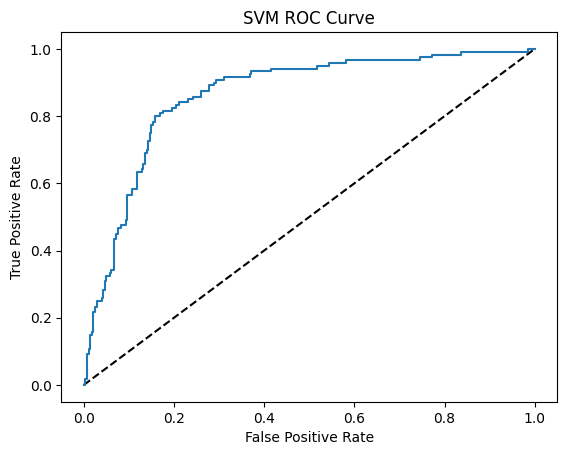

In [26]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(svr_default_results['true_labels'], svr_default_results['predictions'] )
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.show()

### Optimized SVM regressor

In [27]:
# Define the parameter values used in GridSearch for the optimized model
estimator_SVR = SVR(gamma = 'auto')
parameters_SVR = {
    'C':(0.1,1, 10, 100), 
    'kernel': ('linear', 'poly', 'rbf'),
    'coef0': (0.0, 10.0, 1.0)}   

In [28]:
# Find the optimal parameter values
grid_search_SVR = GridSearchCV(
    estimator=estimator_SVR,
    param_grid=parameters_SVR,
    scoring = 'balanced_accuracy',
    n_jobs = -1,
    cv = 5
)

In [29]:
# Fit the model
SVR_1 = grid_search_SVR.fit(train_features, train_labels)
y_pred_SVR1 = SVR_1.predict(test_features)
svr1_predicted_labels = get_labels(0.5, y_pred_SVR1)

C:\Users\20192059\.conda\envs\adv_programming\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


accuracy 0.7333333333333334
specificity 0.8892857142857142
sensitivity 0.4666666666666667


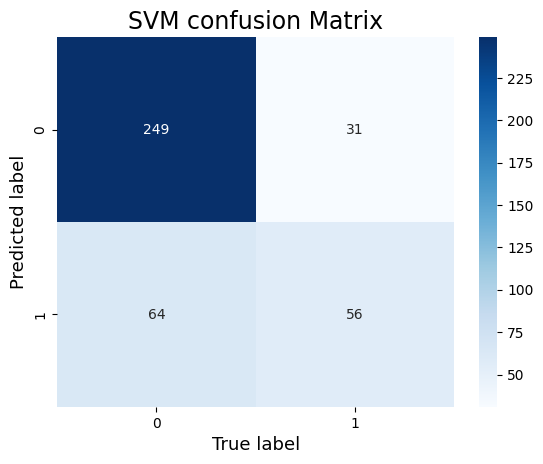

In [30]:
# Calculate the balanced accuracy
d={'predictions':y_pred_SVR1, 'predicted_labels':svr1_predicted_labels, 'true_labels':test_labels}
svr_optimized_results = pd.DataFrame(d) 
#print(svr_optimized_results)

svr_optimized_acc = metrics.balanced_accuracy_score(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels'] )
print("accuracy", rf_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels']).ravel()
cm = confusion_matrix(svr_optimized_results['true_labels'], svr_optimized_results['predicted_labels'])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('True label',fontsize=13)
plt.xlabel('Predicted label',fontsize=13)
plt.title('SVM confusion Matrix',fontsize=17)
plt.show()

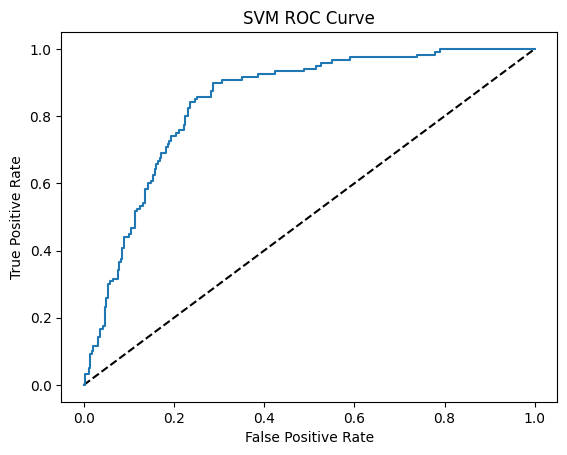

In [31]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(svr_optimized_results['true_labels'], svr_optimized_results['predictions'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.show()

### Support vector classifier

Make SVM model without optimizing the hyperparameters

In [ ]:
SVC_model_default = SVC()
SVC_model_default.fit(train_features, train_labels)
y_pred_SVC_default =SVC_model_default.predict(test_features)

Define the parameter values used in GridSearch

In [ ]:
estimator_SVM = SVC(gamma = 'auto')
parameters_SVM = {
    'C':(0.1,1, 10, 100), #(0.1, 15.0, 0.1)
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'coef0': (0.0, 10.0, 1.0),
    'shrinking': (True, False)}   

Find the optimal parameter values 

In [ ]:
grid_search_SVM = GridSearchCV(
    estimator=estimator_SVM,
    param_grid=parameters_SVM,
    scoring = 'balanced_accuracy',
    n_jobs = -1,
    cv = 5
)

Fit the model

In [ ]:
SVM_1 = grid_search_SVM.fit(train_features, train_labels)
y_pred_SVM1 = SVM_1.predict(test_features)

Evaluate the performance

In [ ]:
default_acc = metrics.balanced_accuracy_score(test_labels, y_pred_SVC_default)
optimized_acc = metrics.balanced_accuracy_score(test_labels, y_pred_SVM1)
print(default_acc)
print(optimized_acc)

## K-nearest Neighbor

### K-nearest Neighbor regressor

In [45]:
# Make the KN model and train it
KN_reg = neighbors.KNeighborsRegressor(n_neighbors = int(math.sqrt(df_smiles_tested.shape[0])))
KN_reg.fit(train_features, train_labels)

KNeighborsRegressor(n_neighbors=44)

In [46]:
# Get the predictions on the test set and determine the labels of these predictions
KN_pred = KN_reg.predict(test_features)
KN_predicted_labels = get_labels(0.5, KN_pred)

accuracy 0.7446428571428572
specificity 0.8892857142857142
sensitivity 0.6


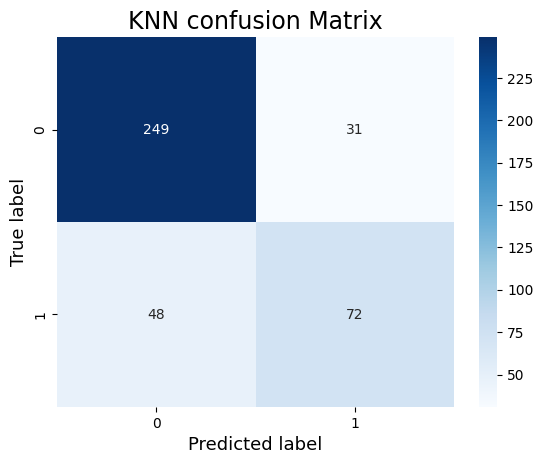

In [53]:
# Calculate the accuracy
d={'predictions':KN_pred, 'predicted_labels':KN_predicted_labels, 'true_labels':test_labels}
kn_results = pd.DataFrame(d) 
#print(kn_results)

kn_acc = metrics.balanced_accuracy_score(kn_results['true_labels'], kn_results['predicted_labels'] )
print("accuracy", kn_acc)

# Calculate metrics
tn, fp, fn, tp = confusion_matrix(kn_results['true_labels'], kn_results['predicted_labels']).ravel()
cm = confusion_matrix(kn_results['true_labels'], kn_results['predicted_labels'])
specificity = tn / (tn+fp)
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print("specificity", specificity)
print("sensitivity", sensitivity)

# Make confusion matrix
sns.heatmap(cm,annot=True, cmap="Blues", fmt='g')
plt.ylabel('True label',fontsize=13)
plt.xlabel('Predicted label',fontsize=13)
plt.title('KNN confusion Matrix',fontsize=17)
plt.show()

In [48]:
KN_pred[1]

0.20454545454545456

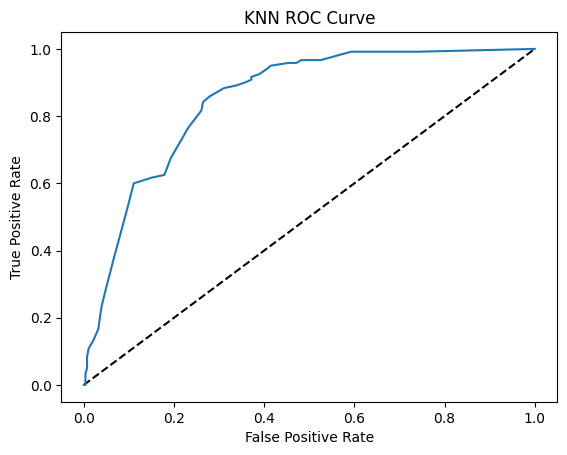

In [49]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(kn_results['true_labels'], kn_results['predictions'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.show()

### K-nearest Neighbor classifier

In [ ]:
KN_clf=neighbors.KNeighborsClassifier(n_neighbors=5)
KN_clf.fit(train_features, train_labels)

Predictions

In [ ]:
KN_preds = KN_clf.predict(test_features)
#print(KN_preds)
print ("accuracy of the training set",KN_clf.score(train_features, train_labels))
print("accuracy of the test set" ,KN_clf.score(test_features, test_labels))

default_acc = metrics.balanced_accuracy_score(test_labels, KN_preds)
print("Default accuracy of the test set",default_acc)

### Results on test set

### Get descriptors

In [ ]:
allDescrs = []
for _, row in df_test_smiles.iterrows():
    mol = row['SMILES']
    m = Chem.MolFromSmiles(mol)
    descriptors = getMolDescriptors(m)
    allDescrs.append(descriptors)
    
df_test_descr = pd.DataFrame(allDescrs)

### Clean data

In [ ]:
df_test_nonzero = df_test_descr.drop(columns=bad_descr)
df_test_noCorr = df_test_nonzero.drop(columns=to_drop)

### PCA

In [ ]:
df_test_scaled = scaler.fit_transform(df_test_noCorr)
principalComponents = pca.fit_transform(df_test_scaled)
principalDf_test = pd.DataFrame(data = principalComponents)
print(principalDf_test)

### Get predictions

In [ ]:
test_features = np.array(principalDf_test)
KN_pred_test = KN_reg.predict(test_features)
test_labels = get_labels(0.5, KN_pred_test)

### Get 100 best molecules

In [ ]:
to_be_predicted = 100 #test_labels.sum() #100 in geval van assignment

d={'SMILES':df_test_smiles['SMILES'],'predictions':test_labels}
best_scores = pd.DataFrame(d).nlargest(to_be_predicted,columns='predictions')
print(best_scores)